In [1]:
## Long Short Term Memory (LSTM) Recurrent Neural Network (RNN)

## This program considers the past 60 day stock price for predictions.

## Current features are daily Close, Open, High, Low, and Volume. These will likely be tweaked in subsequent analyses over time to possible include:
#   Difference between 50 day moving average and 200 day moving average
#   52 week high, low, moving average
#   Difference between 52 week average volume and current volume


In [2]:
# !pip install --upgrade pandas-datareader
# !pip install yfinance

<h1>Importing Dependencies</h1>

In [3]:
# Imports

import math
import pandas_datareader.data as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Flatten
from keras import optimizers, callbacks
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('fivethirtyeight')


<h1>Gathering Data</h1>

In [4]:
# Data gathering
import yfinance as yf
yf.pdr_override()
df = web.get_data_yahoo('MSFT', start='2017-01-01', end='2023-09-10')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,62.790001,62.840000,62.130001,62.580002,57.138729,20694100
2017-01-04,62.480000,62.750000,62.119999,62.299999,56.883076,21340000
2017-01-05,62.189999,62.660000,62.029999,62.299999,56.883076,24876000
2017-01-06,62.299999,63.150002,62.040001,62.840000,57.376129,19922900
2017-01-09,62.759998,63.080002,62.540001,62.639999,57.193508,20382700
...,...,...,...,...,...,...
2023-09-01,331.309998,331.989990,326.779999,328.660004,327.994293,14931200
2023-09-05,329.000000,334.850006,328.660004,333.549988,332.874359,18553900
2023-09-06,333.380005,334.459991,330.179993,332.880005,332.205750,17535800


In [5]:
# Retrieve matrix dimensions: (# rows, # columns)
df.shape

(1682, 6)

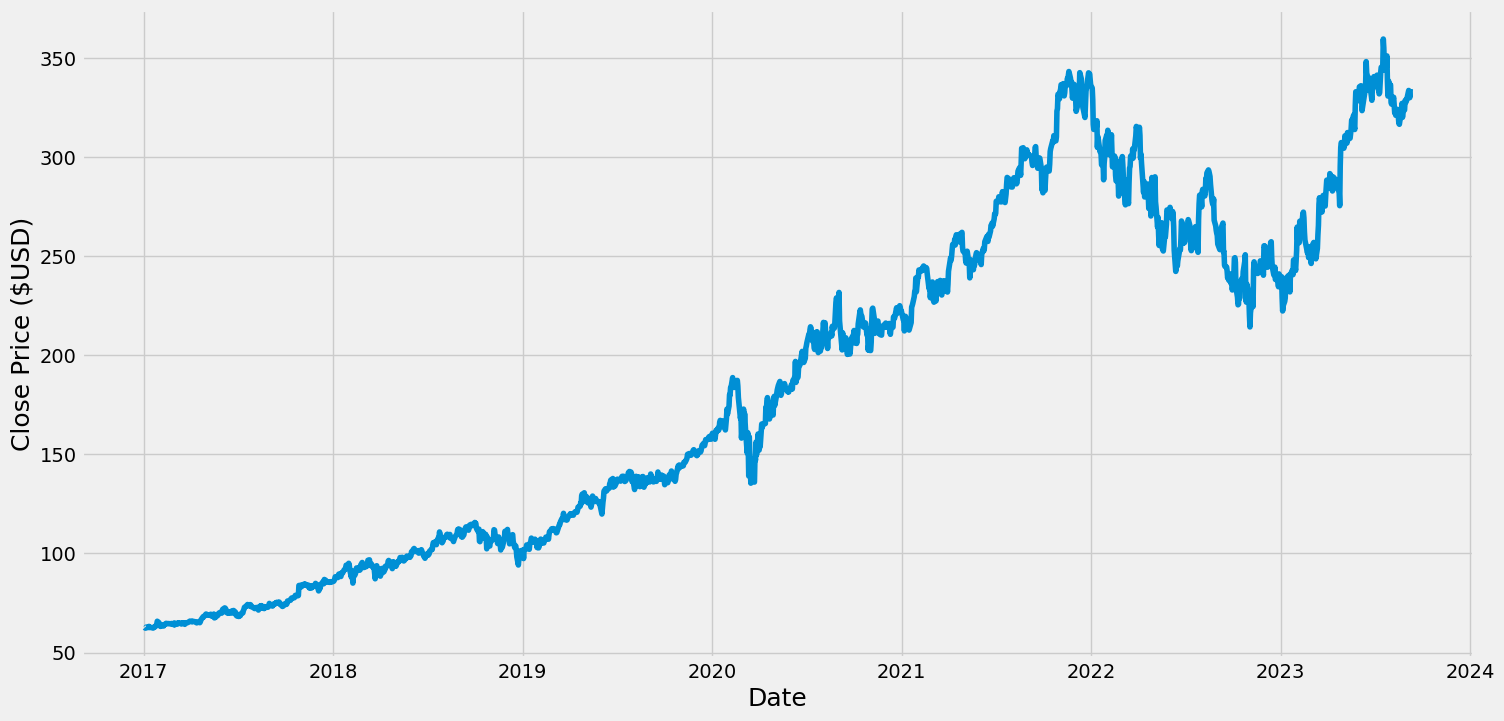

In [6]:
# Visualize closing prices of gathered historic data

plt.figure(figsize=(16,8))
plt.title='Close Price History'
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($USD)', fontsize=18)

plt.show()

<h1>Data Preprocessing</h1>

In [7]:
## Add in derived features for:
#   Difference between 50 day avg close and 200 day avg close
#   Difference bewteen current volume and 50 day avg volume

fifty_day_moving_average_close = []
twohundred_day_moving_average_close = []
twohundred_day_moving_average_volume = []

for i in range(50, len(df)):
    current_close_slice50 = df[i-50:i]['Close'].values
    current_close_avg50 = np.average(current_close_slice50)
    fifty_day_moving_average_close.append(current_close_avg50)
    
    if i >= 200:
        current_volume_slice = df[i-200:i]['Volume'].values
        current_volume_avg = np.average(current_volume_slice)
        twohundred_day_moving_average_volume.append(current_volume_avg)
        
        current_close_slice200 = df[i-200:i]['Close'].values
        current_close_avg200 = np.average(current_close_slice200)
        twohundred_day_moving_average_close.append(current_close_avg200)
        
df = df[200:]
fifty_day_moving_average_close = fifty_day_moving_average_close[150:]

print(df.shape)
print(len(fifty_day_moving_average_close))
print(len(twohundred_day_moving_average_close))
print(len(twohundred_day_moving_average_volume))


(1482, 6)
1482
1482
1482


In [8]:

# Average of past 200 days' closing prices - average of past 50 days' closing prices
df['Moving Average Close Difference'] = list(np.array(fifty_day_moving_average_close) - np.array(twohundred_day_moving_average_close))

# Average of past 50 days' volumes - today's volume
df['Moving Average Volume Difference'] = list(df.loc[:,'Volume'].values - np.array(twohundred_day_moving_average_volume))

print(df.head())

                 Open       High        Low      Close  Adj Close    Volume  \
Date                                                                          
2017-10-18  77.669998  77.849998  77.370003  77.610001  72.082123  13300700   
2017-10-19  77.570000  77.930000  77.349998  77.910004  72.360764  15092800   
2017-10-20  78.320000  78.970001  78.220001  78.809998  73.196663  22866400   
2017-10-23  78.989998  79.339996  78.760002  78.830002  73.215256  20627200   
2017-10-24  78.900002  79.199997  78.459999  78.860001  73.243095  17517200   

            Moving Average Close Difference  Moving Average Volume Difference  
Date                                                                           
2017-10-18                          5.20750                        -9056817.5  
2017-10-19                          5.22875                        -7227750.5  
2017-10-20                          5.25950                          577085.5  
2017-10-23                          5.32495   

/var/folders/jf/h0nc07md5_91djn8f43z96yr0000gn/T/ipykernel_23658/4286510188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Moving Average Close Difference'] = list(np.array(fifty_day_moving_average_close) - np.array(twohundred_day_moving_average_close))
/var/folders/jf/h0nc07md5_91djn8f43z96yr0000gn/T/ipykernel_23658/4286510188.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Moving Average Volume Difference'] = list(df.loc[:,'Volume'].values - np.array(twohundred_day_moving_average_volume))

In [9]:
# Data preprocessing

# Filter to relevant features only
df_train = df.filter(['Close', 'Open', 'High', 'Moving Average Close Difference', 'Moving Average Volume Difference'])


# Isolate dates as independent variables. This may be redundant later but useful in attaching dates to final predictions.
date_train = df.index.strftime("%Y-%m-%d").tolist()
date_train = [pd.to_datetime(d) for d in date_train]

# Convert dataframe to a numpy array
dataset = df_train.values

# Compute row count to train the model on => 80% of data for training
training_data_len = math.ceil(len(dataset) * 0.8)
print(training_data_len)

1186


In [10]:
# Scale the data for preprocessing. Simply normalizes each column's values from 0:1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(np.float32(df_train))  

open_price_scaler  = MinMaxScaler(feature_range=(0,1))
scaled_open_prices = open_price_scaler.fit_transform(np.float32(df_train.filter(['Open'])))

df_train_scaled = scaled_data[0:training_data_len, :]
df_train = df_train[0:training_data_len]
date_train = df_train.index.strftime("%Y-%m-%d").tolist()
date_train = [pd.to_datetime(d) for d in date_train]

x_train = []
y_train = []
batch_size = 60
forecast_size = 1

# Columns in place --> 0: Close, 1: Open, 2: High, 3: Low, 4: Volume
for i in range(batch_size, len(df_train_scaled)-forecast_size+1):
    x_train.append(df_train_scaled[i-batch_size:i, :])        # All features at positions 0 to 59
    y_train.append(df_train_scaled[i+forecast_size-1:i+forecast_size,1])        # Open at position 60
  
# Convert x_train and y_train to numpy arrays
Lstm_x, Lstm_y = np.array(x_train), np.array(y_train)

In [11]:
# Reshape the x_train data set => Add third column
# Lstm_x = np.reshape(Lstm_x, (Lstm_x.shape[0], Lstm_x.shape[1], 1))
Lstm_x.shape

(1126, 60, 5)

<h1>Define the Models</h1>

In [12]:
# Build the LSTM Model(s)
print('y.shape[1]: ', Lstm_y.shape[1])
print('x.shape[1]: ', Lstm_x.shape[1])
print('x.shape[2]: ', Lstm_x.shape[2])

x, y = Lstm_x, Lstm_y

old_model = Sequential()
old_model.add(LSTM(64, return_sequences=True,
              input_shape=(x.shape[1], x.shape[2])))
old_model.add(LSTM(64, return_sequences=False))
old_model.add(Dense(32))
old_model.add(Dense(1))
old_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
old_model.fit(x, y, epochs=16, batch_size=1)
old_model.summary()



random_example_model = Sequential()
random_example_model.add(LSTM(64, input_shape=(x.shape[1], x.shape[2]), return_sequences=True, recurrent_dropout=0))
random_example_model.add(LSTM(64, return_sequences=False, recurrent_dropout=0))
random_example_model.add(Dense(1, activation='relu'))
random_example_model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae'])
random_example_model.fit(x, y, batch_size=1, epochs=8)
random_example_model.summary()


# lstm_fallback_model = Sequential()
# lstm_fallback_model.add(LSTM(64, activation='relu', input_shape=(
#     x.shape[1], x.shape[2]),  return_sequences=True))
# lstm_fallback_model.add(Dropout(0.2))
# lstm_fallback_model.add(BatchNormalization())
# lstm_fallback_model.add(LSTM(32, activation='relu', return_sequences=False))
# lstm_fallback_model.add(Dropout(0.2))
# lstm_fallback_model.add(BatchNormalization())
# lstm_fallback_model.add(Dense(32, activation='relu'))
# lstm_fallback_model.add(Dense(y.shape[1], activation='relu'))
# opt = optimizers.legacy.Adam(lr=0.001, decay=1e-6)
# lstm_fallback_model.compile(
#     loss='mse',
#     optimizer=opt,
#     metrics=['mae']
# )
# es = callbacks.EarlyStopping(
#     monitor='loss', patience=15, restore_best_weights=True)
# lstm_fallback_model.fit(x, y, epochs=4, verbose=1, callbacks=[
#                         es], validation_split=0.1, batch_size=16)
# lstm_fallback_model.summary()


# Lstm_model1 = Sequential()
# Lstm_model1.add(LSTM(units=50, return_sequences=True,
#                 input_shape=(x.shape[1], x.shape[2])))
# Lstm_model1.add(Dropout(0.2))
# Lstm_model1.add(LSTM(units=50, return_sequences=True))
# Lstm_model1.add(Dropout(0.2))
# Lstm_model1.add(LSTM(units=50, return_sequences=True))
# Lstm_model1.add(Dropout(0.2))
# Lstm_model1.add(LSTM(units=50))
# Lstm_model1.add(Dropout(0.2))
# Lstm_model1.add(Dense(units=1))
# Lstm_model1.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
# es = callbacks.EarlyStopping(
#     monitor='loss', patience=15, restore_best_weights=True)
# Lstm_model1.fit(x, y, epochs=6, validation_split=0.1,
#                 batch_size=64, verbose=1, callbacks=[es])
# Lstm_model1.summary()


# Lstm_model2 = Sequential()
# Lstm_model2.add(LSTM(20, return_sequences=True,
#             input_shape=(x.shape[1], x.shape[2])))
# Lstm_model2.add(Dropout(0.2))
# Lstm_model2.add(BatchNormalization())
# Lstm_model2.add(LSTM(15,return_sequences=True))
# Lstm_model2.add(Dropout(0.2))
# Lstm_model2.add(BatchNormalization())
# Lstm_model2.add(LSTM(15))
# Lstm_model2.add(Dropout(0.2))
# Lstm_model2.add(BatchNormalization())
# Lstm_model2.add(Dense(16, activation='relu'))
# Lstm_model2.add(Dense(1))
# adam = optimizers.legacy.Adam(0.001)
# Lstm_model2.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae'])
# es = callbacks.EarlyStopping(
#     monitor='loss', patience=15, restore_best_weights=True)
# Lstm_model2.fit(x, y, validation_split=0.2, epochs=6,
#             batch_size=64, verbose=1, callbacks=[es])
# Lstm_model2.summary()


y.shape[1]:  1
x.shape[1]:  60
x.shape[2]:  5
Epoch 1/16
1126/1126 [==============================] - 11s 9ms/step - loss: 0.0018 - mae: 0.0288
Epoch 2/16
1126/1126 [==============================] - 10s 9ms/step - loss: 8.7034e-04 - mae: 0.0220
Epoch 3/16
1126/1126 [==============================] - 11s 10ms/step - loss: 7.0846e-04 - mae: 0.0199
Epoch 4/16
1126/1126 [==============================] - 10s 9ms/step - loss: 5.3667e-04 - mae: 0.0166
Epoch 5/16
1126/1126 [==============================] - 10s 9ms/step - loss: 4.7529e-04 - mae: 0.0156
Epoch 6/16
1126/1126 [==============================] - 10s 9ms/step - loss: 2.9508e-04 - mae: 0.0127
Epoch 7/16
1126/1126 [==============================] - 10s 9ms/step - loss: 2.5573e-04 - mae: 0.0120
Epoch 8/16
1126/1126 [==============================] - 10s 9ms/step - loss: 3.2464e-04 - mae: 0.0128
Epoch 9/16
1126/1126 [==============================] - 11s 9ms/step - loss: 3.2052e-04 - mae: 0.0127
Epoch 10/16
1126/1126 [================

<h1>Predicting</h1>

In [13]:
# Create the testing data set

# Array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60:, :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, 1]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, :])

x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(
    x_test, (x_test.shape[0], x_test.shape[1], x_test.shape[2]))

In [14]:
# Retrieve models' predicted price values
old_model_predictions = old_model.predict(x_test)
print(old_model_predictions.shape)

random_example_model_predictions = random_example_model.predict(x_test)
print(random_example_model_predictions.shape)

# fallback_model_predictions = lstm_fallback_model.predict(x_test)
# print(fallback_model_predictions.shape)

# model1_predictions = Lstm_model1.predict(x_test)
# print(model1_predictions.shape)

# model2_predictions = Lstm_model2.predict(x_test)
# print(model2_predictions.shape)

10/10 [==============================] - 0s 6ms/step
(296, 1)
10/10 [==============================] - 0s 7ms/step
(296, 1)


In [15]:

# Unscale predictions to compare to original closing prices (y_test)
old_model_predictions = open_price_scaler.inverse_transform(
    old_model_predictions)
# Unscale predictions to compare to original closing prices (y_test)
random_example_model_predictions = open_price_scaler.inverse_transform(
    random_example_model_predictions)
# # Unscale predictions to compare to original closing prices (y_test)
# fallback_model_predictions = open_price_scaler.inverse_transform(
#     fallback_model_predictions)
# # Unscale predictions to compare to original closing prices (y_test)
# model1_predictions = open_price_scaler.inverse_transform(model1_predictions)
# # Unscale predictions to compare to original closing prices (y_test)
# model2_predictions = open_price_scaler.inverse_transform(model2_predictions)

In [16]:
# Evaluate root mean square error (RMSE) => Standard deviation of the residuals

old_model_rmse = np.sqrt(np.mean(old_model_predictions - y_test)**2)
random_example_model_rmse = np.sqrt(np.mean(random_example_model_predictions - y_test)**2)
# fallback_model_rmse = np.sqrt(np.mean(fallback_model_predictions - y_test)**2)
# model1_rmse = np.sqrt(np.mean(model1_predictions - y_test)**2)
# model2_rmse = np.sqrt(np.mean(model2_predictions - y_test)**2)

print(old_model_rmse,
      random_example_model_rmse)
      # fallback_model_rmse,
      # model1_rmse,
      # model2_rmse)

1.1005021172600824 200.755574767654


<h1>Results</h1>

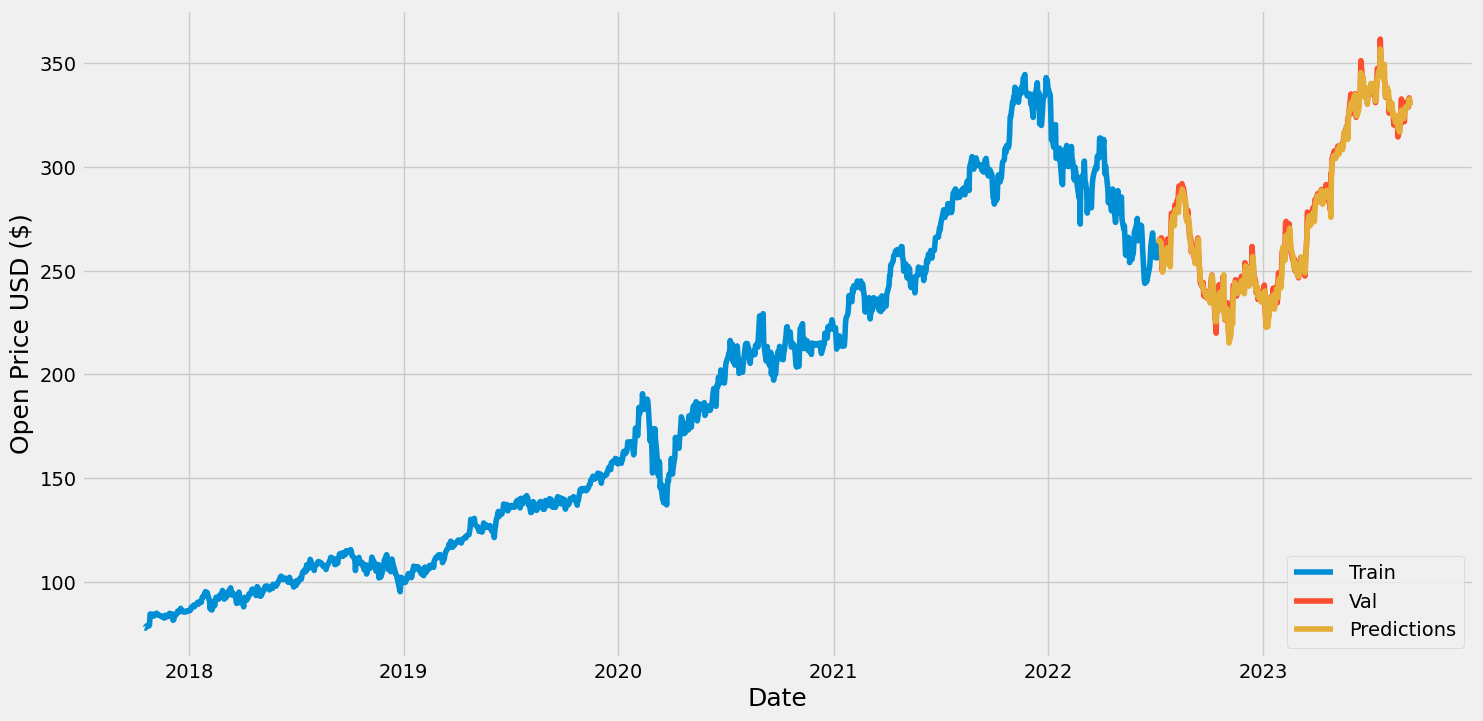

In [17]:
# Plot the data
data = df.filter(['Open'])
train = data[:training_data_len].copy()
valid = data[training_data_len:].copy()

valid['Predictions'] = old_model_predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title='Old Model'
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train['Open'])
plt.plot(valid[['Open', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

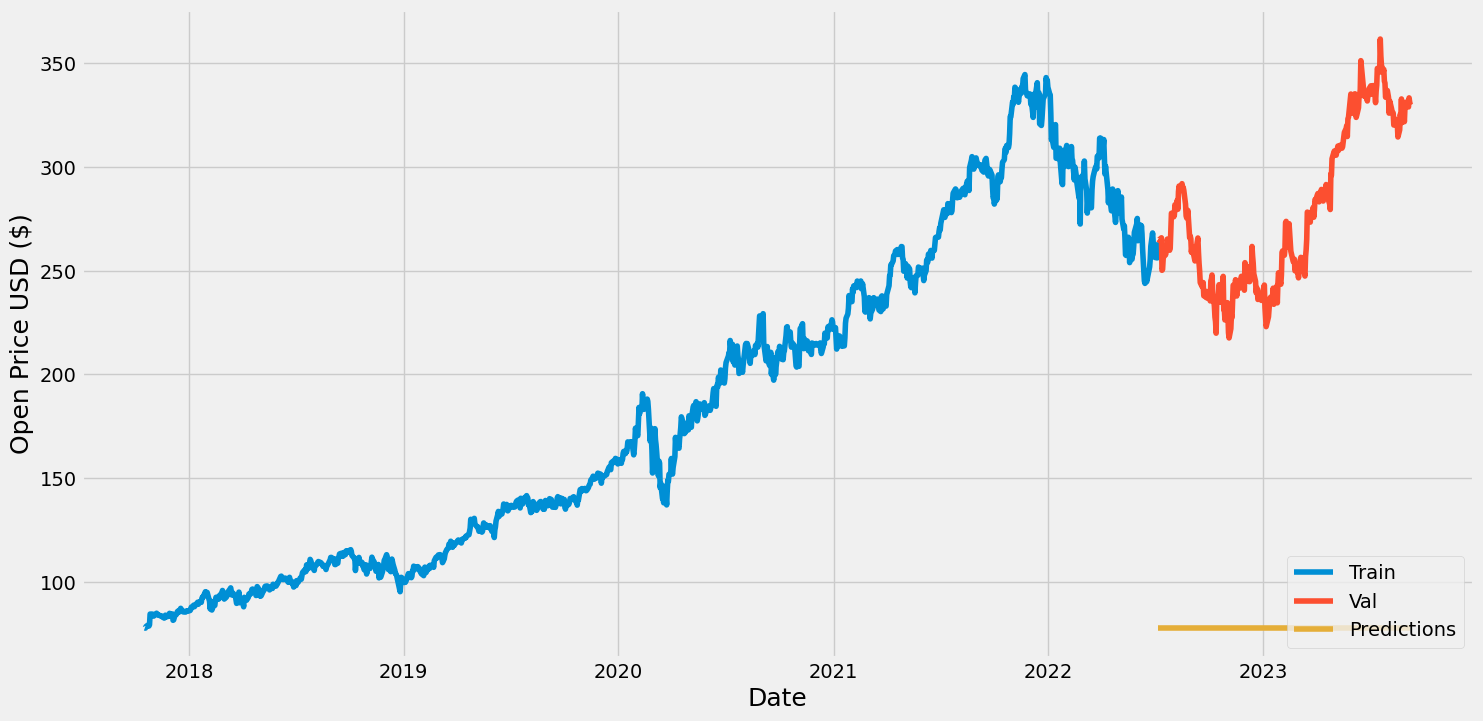

In [18]:
# Plot the data
data1 = df.filter(['Open'])
train1 = data1[:training_data_len].copy()
valid1 = data1[training_data_len:].copy()

valid1['Predictions'] = random_example_model_predictions

# Visualize the data
plt.figure(figsize=(16,8))
plt.title='Other Model'
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD ($)', fontsize=18)
plt.plot(train1['Open'])
plt.plot(valid1[['Open', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

<h1>Further Analysis</h1>

In [19]:
# Check model's efficacy at predicting if stock price is higher or lower than previous day
total_days = valid.shape[0]

preds = valid['Predictions'].values
actual_opens = valid['Open'].values

good = 0
bad = 0

for i in range(1, total_days-1):
    actual_dif = preds[i] - preds[i-1]
    predicted_dif = actual_opens[i] - actual_opens[i-1]
    and_signs = (actual_dif > 0 and predicted_dif > 0) or (actual_dif < 0 and predicted_dif < 0)
    
    if and_signs:
        good += 1
    else:
        bad +=1
        
print('good: ', good)
print('bad: ', bad)
    

good:  201
bad:  93


In [20]:
# Check model1's efficacy at predicting if stock price is higher or lower than previous day
total_days = valid1.shape[0]

preds1 = valid1['Predictions'].values
actual_opens1 = valid1['Open'].values

good1 = 0
bad1 = 0

for i in range(1, total_days-1):
    actual_dif = preds1[i] - preds1[i-1]
    predicted_dif = actual_opens1[i] - actual_opens1[i-1]
    and_signs = (actual_dif > 0 and predicted_dif > 0) or (actual_dif < 0 and predicted_dif < 0)
    
    if and_signs:
        good1 += 1
    else:
        bad1 +=1
        
print('good: ', good1)
print('bad: ', bad1)
    

good:  0
bad:  294
